In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram,linkage
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

# Cell expression array

In [ ]:
cell_data = np.load('cells_data.npy')
cell_data = np.float32(cell_data)

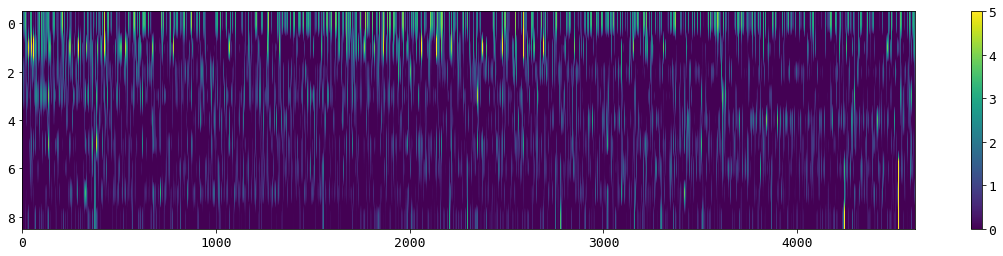

In [ ]:
plt.figure(figsize=(20,4))
plt.imshow(cell_data.T,aspect='auto',vmin=0,vmax=5)
plt.colorbar()

#### Compute the distance matrix and linkage and then access the optimal leaf order using: leaf_order = hierarchy.leaves_list(Z)


In [ ]:
dist_ = pdist(cell_data, 'euclidean')
Z = linkage(dist_, 'complete')
leaf_order = hierarchy.leaves_list(Z)

### Display the matrix ordered using leaf_order

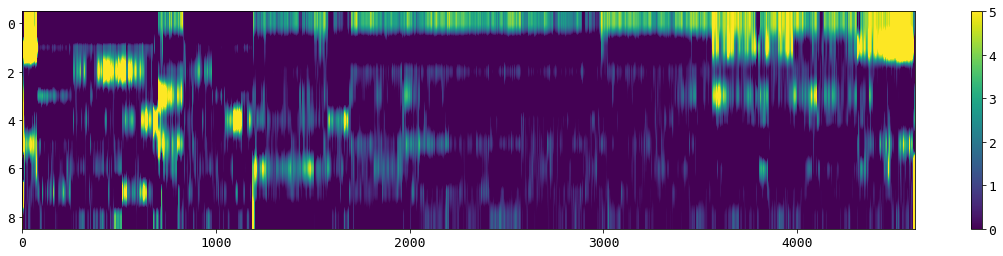

In [ ]:
plt.figure(figsize=(20,4))
plt.imshow(cell_data[leaf_order,:].T,aspect='auto',vmin=0,vmax=5)
plt.colorbar()

# Organize your cell array using Rastermap

### Check how rastermap performs in comparison with optimal leaf order
> Check documentation  https://github.com/MouseLand/rastermap

In [ ]:
!pip install rastermap

In [ ]:
from rastermap import Rastermap

model = Rastermap(n_components=1, n_X=30, nPC=200, init='pca')
embedding = model.fit_transform(cell_data)
isort = np.argsort(model.embedding[:,0])

nmin 9
0.0060465335845947266
0.014242172241210938
0.019175052642822266
0.022406339645385742
(28, 30)
(60,)
1.0
time; iteration;  explained PC variance
0.01s     0        0.2145      2
0.12s    10        0.6991      4
0.21s    20        0.8122      8
0.27s    30        0.8586      18
0.34s    40        0.8790      28
0.42s    50        0.8880      28
0.48s   final      0.8865
0.49s upsampled    0.8865


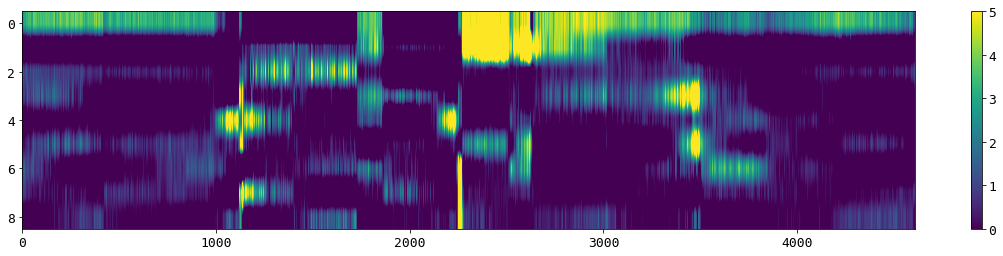

In [ ]:
plt.figure(figsize=(20,4))
plt.imshow(cell_data[isort,:].T,aspect='auto',vmin=0,vmax=5)
plt.colorbar()

# Clustering of behavioral data

# Load Data

> Upload the dataset:https://drive.google.com/u/1/uc?export=download&confirm=HsCs&id=1NyiWFaMNneIP7eLhM5xFXePbCcgOlxvm

In [ ]:
f = h5py.File('zebrafish_bout.mat','r')

In [ ]:
bout_cat = f['bout_cat'][:] # Label assigned by https://pubmed.ncbi.nlm.nih.gov/29307558/
tail_angle = f['tail_angle'][:] # Raw data
score = f['score'][:]  # Principal component of the behavioral feature

# Subsampling for reducing memory footprint
N = bout_cat.shape[1]
N_max = 10000
id = np.random.permutation(N)[0:N_max]
bout_cat = bout_cat[:,id]
tail_angle = tail_angle[:,id]
score = score[:,id]

# Use scatter plot to display the Score

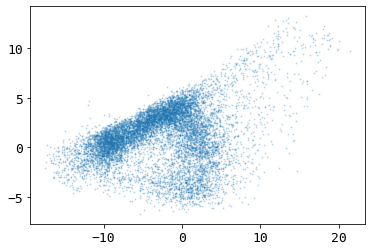

In [ ]:
plt.figure
plt.scatter(score[0,:],score[1,:],s=1,alpha=0.2)
plt.show()

# Run Hierarchical Clustering

In [ ]:
def get_linkage(model):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

### Use agglomerative clustering to build a dendrogram of the score

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.2, n_clusters=None,linkage='average')#,connectivity=knn_graph)
model = model.fit(score.T)

#### Display the dendrogram 
> don't forget the truncate_mode="level" option for speed

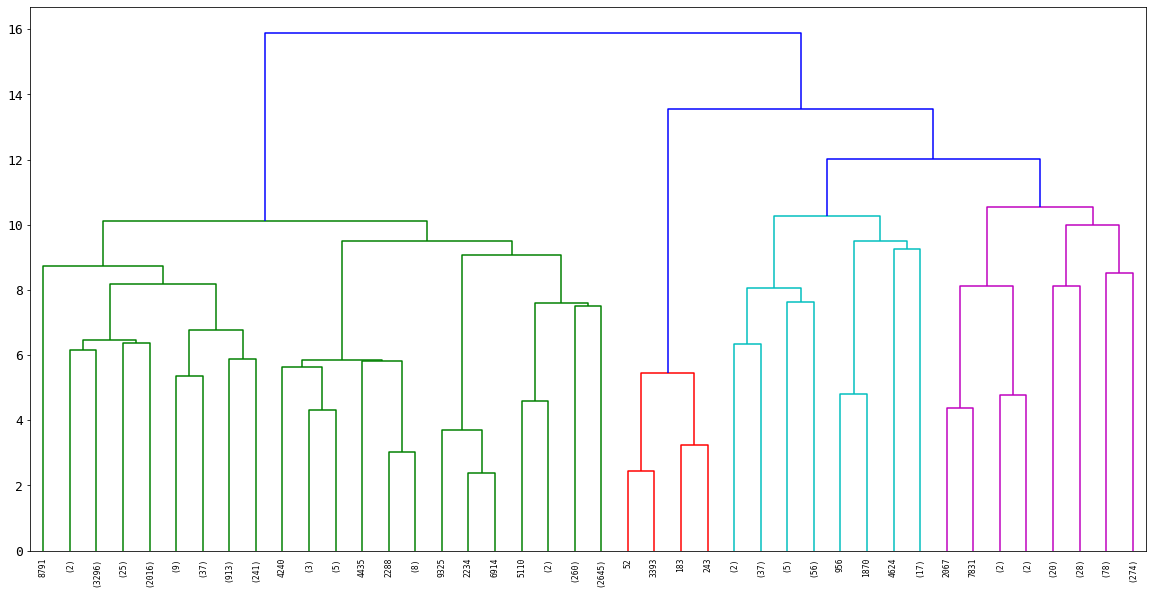

In [ ]:
Z = get_linkage(model)
plt.figure(figsize=(20,10))
dendrogram(Z,truncate_mode="level", p=5)
plt.show()

### Evaluate clusters using the silhouette_score

> tips: you can use fcluster with criterion criterion='maxclust' to get label from dendrogram

In [ ]:
from sklearn.metrics import calinski_harabasz_score,davies_bouldin_score,silhouette_score


In [ ]:
from sklearn.metrics import calinski_harabasz_score,davies_bouldin_score,silhouette_score

cluster_score = np.zeros(100)

for i in range(100):
    # setting distance_threshold=0 ensures we compute the full tree.
    label = fcluster(Z, i+2, criterion='maxclust')    
    cluster_score[i] = silhouette_score(score.T, label)

    

#### Display the silhouette_score

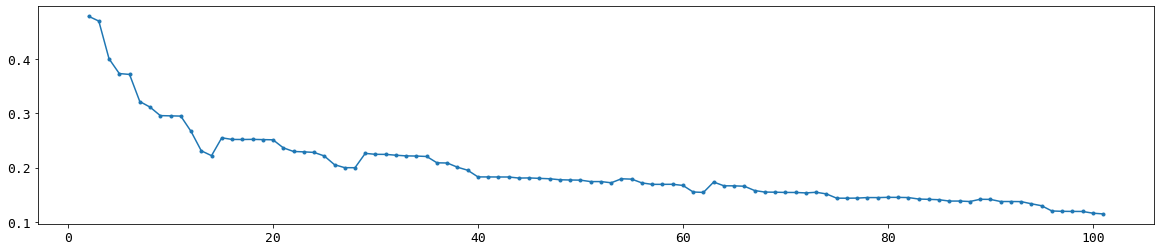

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(np.arange(2,102),cluster_score,'.-')
plt.show()

### Display the scatter plot of score for your choice of number of cluster



In [ ]:
label = fcluster(Z,49, criterion='maxclust')

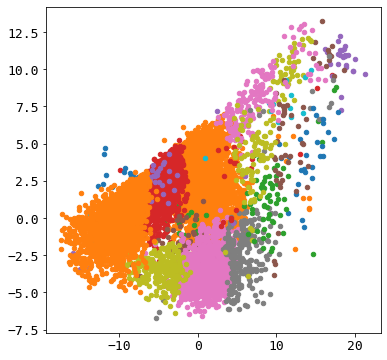

In [ ]:
plt.figure(figsize=(6,6))

for i in np.unique(label).tolist():
    id = np.where(label==i)[0]
    plt.scatter(score[0,id],score[1,id],s=20)
plt.show()


### Display the tail angle from similar cluster

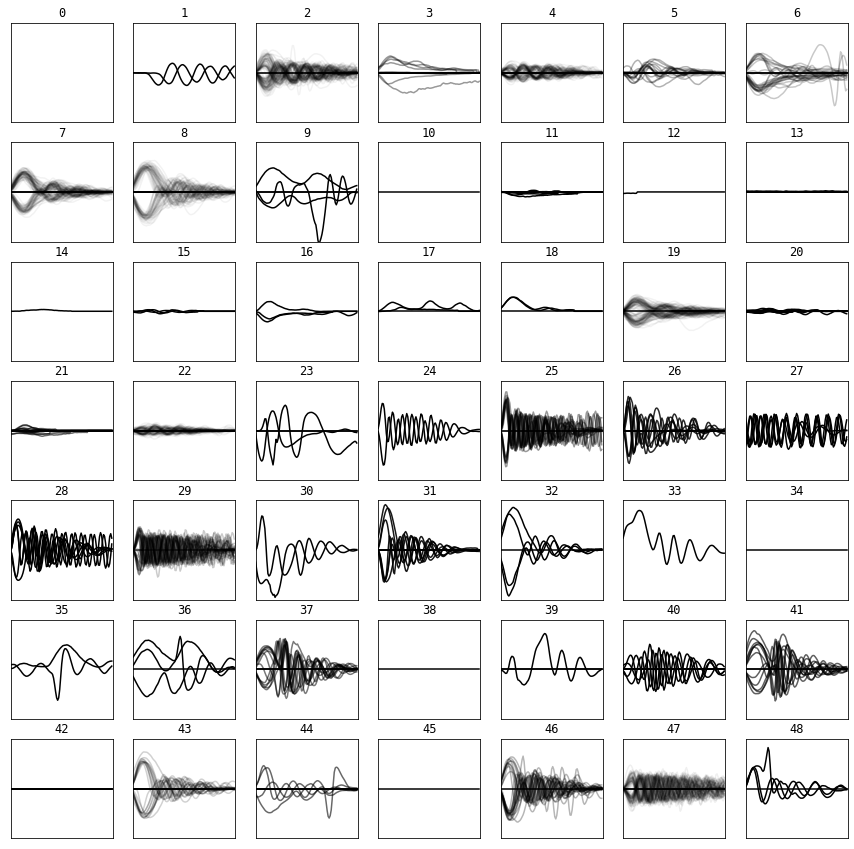

In [ ]:
n = int(np.ceil(np.sqrt(len(np.unique(label)))))

fig, ax = plt.subplots(facecolor='white',figsize=(15,15))
plt.rc('font', family='monospace', serif='Courier New')
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('axes', labelsize=13)
gs = fig.add_gridspec(n, n)
ax.set_yticks([])
ax.set_xticks([])
# Hide grid lines
ax.grid(False)
ax.set_frame_on(False)

for i in range(n):
    for j in range(n):
        ax = fig.add_subplot(gs[i,j])
        ax.set_ylim(-4.5,4.5)
        ax.set_xlim(0,100)
        ax.set_yticks([])
        ax.set_xticks([])
        try:
            k = int(j+i*n)
            ax.set_title(str(k))
            id = np.where(label==k)[0]
            id = id[:min(200,len(id))]
            ax.plot(tail_angle[:100,id],'k',alpha=min(1,10/len(id)))
            ax.set_xlim(0,100)
        except:
            pass

plt.show()

# Bonus point : can you cluster from tail_angle without using the score